# Charon4 txt to Python

The results of this script are stored in `..\Alsdorf\Daten\my_database`. The goal of this database is to contain all data in an easy to read format.

# Import 2018 data; different export settings
The following screenshot shows the expected settings while exporting the 2018 data. They are exported per day, for easier reading of the different cable lengths.

<img src=".\pictures\Charon4_export_window_txt_2018_day.png" alt="drawing" width="500"/>

In [1]:
# To-Do 
# TRT Daten von Sciebo hinzufügen
# Temp. Sonde in Eduardschacht angucken und vergleichen

version="v1_0"
# Changelog
#v1_0: extracted this notebook from charon4_txt_to_python
# resolved a problem where the data with 0.5 sampling was imported into a to big dataframe; 
# pickle and csv data are now saved with the same format
#

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date, timedelta
from collections import defaultdict
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates
from shutil import copy2 as copy_file
import pickle

# import my User defined functions
from my_func_mvw.functions import get_abspath, all_days_of_year, calculate_measurements_per_day, improve_n_meas_pday

In [2]:
# Input
#path to working directory
#mit \[-]\ im Pfad funktioniert die get_abspath Funktion nicht

##############Input##############################
path_to_controller=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt" #also used for saving plots
data_save_csv    =True # True False; data saving takes about 1 min.
data_save_pickle =True # True False; takes less than 1 s.
plot_save        =True # True False
##################################################

In [3]:
controller=3188 # 3188: Alsdorf
# generate all requested paths, some paths may be empty
path_to_controller_2018_day=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt\2018_export_by_day"
year="2018"
channels=[1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8]
months=[1,2,3,4,5,6,7,8,9,10,11,12] #[1,2,3,4,5,6,7,8,9,10,11,12]
paths_for_activate_2018_day={}

for channel in channels:
    for month in months:
        paths_for_activate_2018_day[f"temp_ch{channel}_year2018_month{month}"] = path_to_controller_2018_day + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate_2018_day

In [4]:
def import_temp_to_df_2018(path):
    """"""
    one_file = pd.read_csv(path,decimal=".",delimiter="\t",skiprows=7,index_col=0)
    one_file = one_file.drop(one_file.columns[0:2],axis=1)
    one_file.index = pd.to_datetime(one_file.index, infer_datetime_format=True)
    #one_file.rename(columns=lambda x: float(x), inplace=True) # when sampling is 0.5 m, int values are not sufficient
    # thats easier to read, and has the same result?
    one_file.columns = one_file.columns.astype(float)
    one_file.index.names = ['Date']
    one_file.columns.names=["Length [m]"]
    return one_file

def create_base_dataframe(n_columns,sampling_05=False):
    """"""
    if sampling_05==False: #sampling interval is 1 m
        df=pd.DataFrame(columns=np.linspace(0,n_columns-1,n_columns))
        df.rename(columns=lambda x: float(x), inplace=True) #to have all 2018 data data as float
    elif sampling_05==True:
        df=pd.DataFrame(columns=np.linspace(0,(n_columns-1)/2,n_columns))
    df.index.names = ['Date']
    df.columns.names=["Length [m]"]
    return df

In [5]:
%%time
#Wall time: 2min 17s

# TO-DO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# check if one day folder contains more than one file

# create dic depending on channelnumber and cable length
cable_lengths_2018=[233,1314,2340,1171,1170,798,259,799,268,1352,676,223,378,250,800]
#all_files=defaultdict(dict) #two level defaultdict
#all_files = defaultdict(lambda: defaultdict(dict)) ##two level defaultdict, different style
# data_2018_day, is named day because the data is exported different from Charon4, than the data from the other years
data_2018_day=my_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict))) #three level defaultdict
for channel in channels:
    for cable_type in cable_lengths_2018:
        for month in months:

            if cable_type in [233,1314,1171,1170,798,259,799,268,676,223,378,250,800]: # sampling interval is 1 m
                data_2018_day[cable_type][str(channel)][str(month)] = create_base_dataframe(cable_type)

            elif cable_type in [2340, 1352]: #sampling interval is 0.5 m instead of 1 m
                data_2018_day[cable_type][str(channel)][str(month)] = create_base_dataframe(cable_type,sampling_05=True)

# Read the data
count_ParserError=0
for channel in channels:
    for month in months: #path could be empty --> no data 
        my_path=paths_for_activate_2018_day[f"temp_ch{channel}_year2018_month{month}"]
        all_my_paths=get_abspath(my_path + "\*\*") 

        for file in all_my_paths:
            # check cable length and create different dataframes

            try: 
                # Read Data
                one_file = import_temp_to_df_2018(file)

                #check cable length and put it in corresponding dataframe
                n_columns=len(one_file.columns)
                data_2018_day[n_columns][str(channel)][str(month)]=pd.concat([data_2018_day[n_columns][str(channel)][str(month)],one_file],axis=0)
                # doppelte datums tauchen auf

            # except ParserError, file contains data with different cable lengths
            # With this solution I will skip these data.
            except pd.errors.ParserError:
                count_ParserError+=1
                pass

print(f"{count_ParserError} ParserErrors were skipped. This means {count_ParserError} days with data are not read!")        

2 ParserErrors were skipped. This means 2 days with data are not read!
Wall time: 1min 55s


In [6]:
# remove empty dataframes and delete the corresponding key, so my previous defined functions can be used
# without list() RuntimeError: dictionary changed size during iteration occurs
for cable_type in list(data_2018_day.keys()):
    for channel in list(data_2018_day[cable_type].keys()):
        for month in list(data_2018_day[cable_type][channel].keys()):

            if data_2018_day[cable_type][channel][month].shape[0] == 0: # number pf rows of dataframe 0 == empty
                del data_2018_day[cable_type][channel][month] # month key will be deleted

#difference to other years:
# different cable length exists --> they have there own key in dic
# column names are not int; due to sampling interval of 0.5 m in some cable length

# count meas per day variables for 2018_day
df_unique_days_month_2018_day={}
n_meas_pday_2018_day={}
n_meas_pday_2018_day_with0={}
for cable_type in cable_lengths_2018:
    df_unique_days_month_2018_day[cable_type], n_meas_pday_2018_day[cable_type] = calculate_measurements_per_day(data_2018_day[cable_type])
    n_meas_pday_2018_day_with0[cable_type] = improve_n_meas_pday(n_meas_pday_2018_day[cable_type] , year=2018)


2018-11-16 has less than 10 measurements per day in channel 1
2018-11-09 has less than 10 measurements per day in channel 2
2018-11-09 has less than 10 measurements per day in channel 6


In [7]:
def save_helper(data_2018_day,channel,cable_length,create_base_dataframe=create_base_dataframe):
    """merges different month for each channel into one dataframe"""
    if cable_length in [233,1314,1171,1170,798,259,799,268,676,223,378,250,800]: # sampling interval is 1 m
        data_2018_day_save = create_base_dataframe(cable_length)
    elif cable_length in [2340, 1352]: #sampling interval is 0.5 m instead of 1 m
        data_2018_day_save = create_base_dataframe(cable_length,sampling_05=True)

    for month in data_2018_day[cable_length][channel].keys():
        one_file = data_2018_day[cable_length][channel][month]
        data_2018_day_save = pd.concat([data_2018_day_save , one_file],axis=0) 

    return data_2018_day_save

In [8]:
%%time
#Wall time: 49.1 s
data_save_csv = True
# Save Data 2018 csv
if data_save_csv:
    save_to_path = path_to_controller + r"\..\..\my_database\temp_2018_Controller3188\csv"
    #path_to_controller + "\..\..\my_database"
    for cable_length in data_2018_day.keys():
        for channel in data_2018_day[cable_length].keys():
            data_2018_day_save = save_helper(data_2018_day,channel,cable_length)

            # Save data
            if data_2018_day_save.shape[0]!=0: # dataframe contains rows (with data)
                filename=f"\\temp_cablelength{cable_length}_ch{channel}.csv"
                data_2018_day_save.to_csv(save_to_path + filename)

Wall time: 45.3 s


In [9]:
%%time
#Wall time: 11.7 s
data_save_pickle = True
# Save Data 2018 pickle
if data_save_pickle:
    def write_pickle(save_to:str,data_2018_day):
        #Function to write pickle Files
        for cable_length in data_2018_day.keys():
            for channel in data_2018_day[cable_length].keys():
                data_2018_day_save = save_helper(data_2018_day,channel,cable_length)

                #if len(data_2018_day[cable_length][channel].keys()) != 0:
                if data_2018_day_save.shape[0]!=0: # dataframe contains rows (with data)
                    filename=f"\\temp_cablelength{cable_length}_ch{channel}"
                    with open(save_to + filename, 'wb') as handle:
                        pickle.dump(data_2018_day_save, handle, protocol=pickle.HIGHEST_PROTOCOL)


    save_to_path_pickle = path_to_controller + r"\..\..\my_database\temp_2018_Controller3188\pickle"
    write_pickle(save_to_path_pickle,data_2018_day)


    # Load pickle data - test
    def read_pickle(filename:str):
        #Function to read pickle Files
        with open(filename, 'rb') as f:
            return pickle.load(f)
    filename=r"\temp_cablelength378_ch5"
    load_file_pickle = save_to_path_pickle + filename
    test_load_pickle=read_pickle(load_file_pickle)
    #test_load_pickle

Wall time: 18.2 s


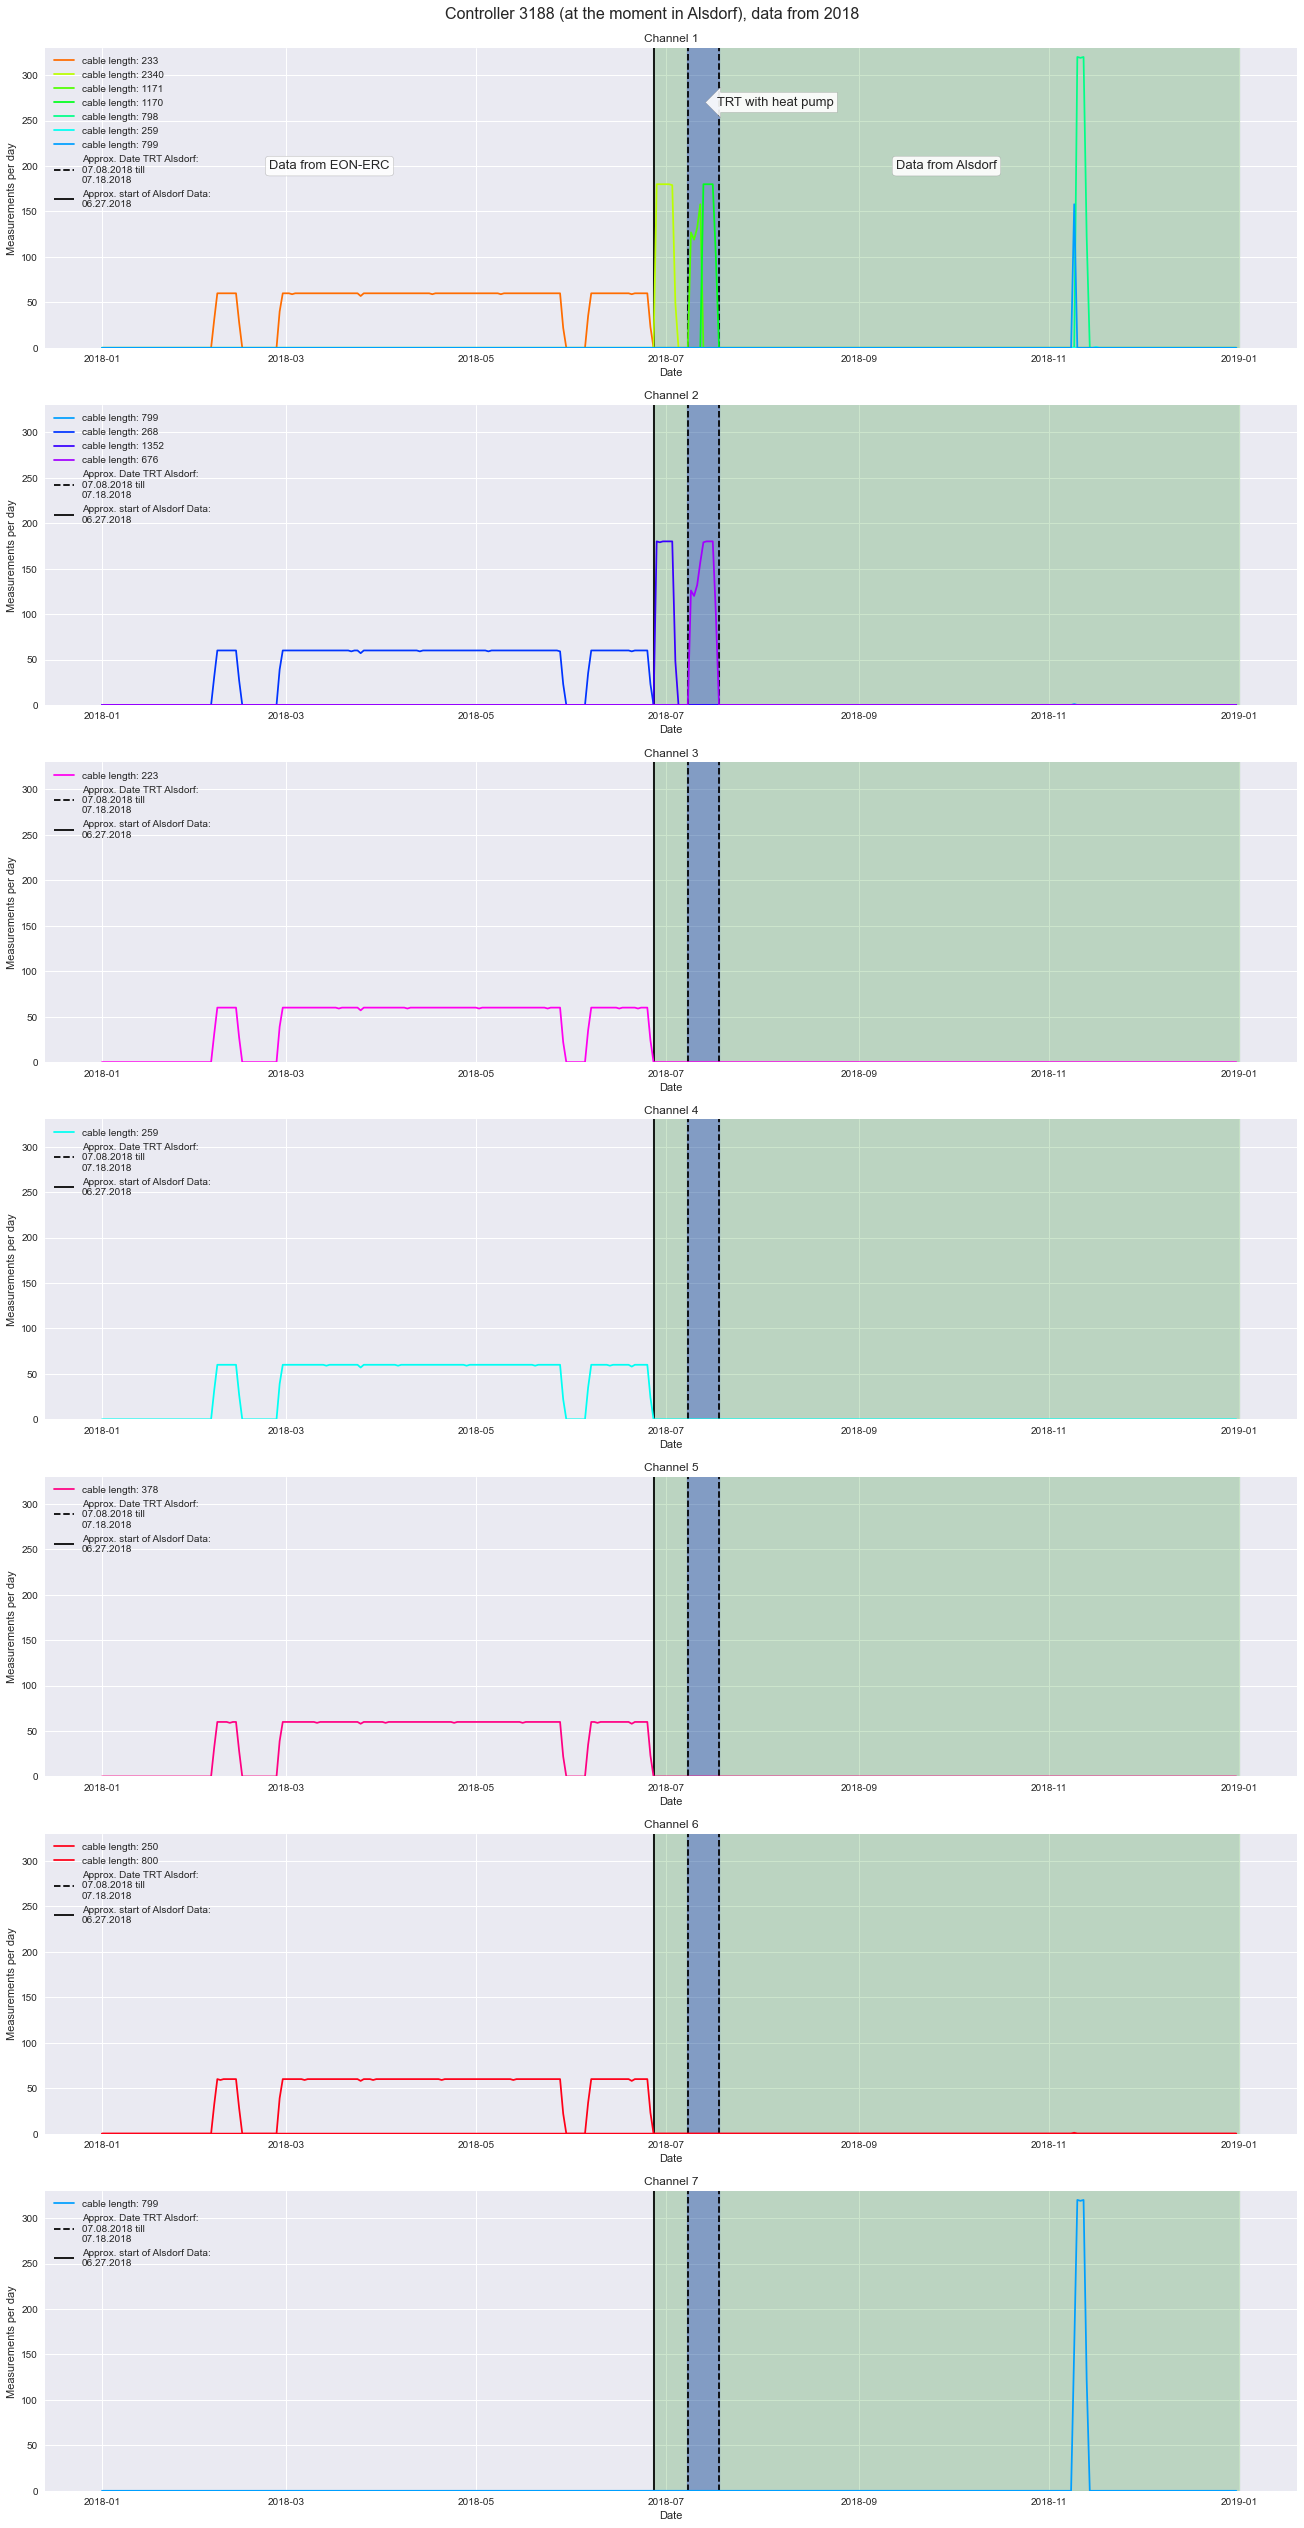

Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m
Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)
All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018


In [10]:
# Plot 2018_day data

# Plot each channel seperate
plt.style.use("seaborn")

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig,axs=plt.subplots(7,1,figsize=[18,35],constrained_layout=True)
fig.suptitle("Controller 3188 (at the moment in Alsdorf), data from 2018", fontsize=16)
c=get_cmap(len(cable_lengths_2018))
for channel in ["1","2","3","4","5","6","7"]:
    n=int(channel)-1

    axs[n].set_ylim(0,330)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")

    # PLOT ACCESSOIREs
    # Plot date of TRT 9-10 Juli 2018, these somehow mark the first measurements in Alsdorf (info from Norbert)
    s_dat_trt="07.08.2018"
    e_dat_trt="07.18.2018"
    start_time_trt=mdates.date2num(pd.to_datetime(s_dat_trt))
    end_time_trt=mdates.date2num(pd.to_datetime(e_dat_trt))
    width_trt= end_time_trt - start_time_trt
    fancy_box=patches.FancyBboxPatch(xy=[start_time_trt,0],width=width_trt,height=350,color="blue",alpha=0.3,boxstyle='square')
    axs[n].add_patch(fancy_box)
    axs[n].vlines(start_time_trt, ymin=0, ymax=330, label=f"Approx. Date TRT Alsdorf:\n{s_dat_trt} till\n{e_dat_trt}", colors="black",linestyles="--")
    axs[n].vlines(end_time_trt, ymin=0, ymax=330, colors="black",linestyles="--")
    # Plot Approximated beginn of Alsdorf Data
    s_dat_als="06.27.2018"
    start_time_alsd=mdates.date2num(pd.to_datetime(s_dat_als))
    end_time_alsd=mdates.date2num(pd.to_datetime("01.01.2019"))
    width_alsd = end_time_alsd - start_time_alsd
    axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label=f"Approx. start of Alsdorf Data:\n{s_dat_als}", colors="black",linestyles="-")
    fancy_box=patches.FancyBboxPatch(xy=[start_time_alsd,0],width=width_alsd,height=350,color="green",alpha=0.2,boxstyle='square')
    axs[n].add_patch(fancy_box)

    # PLOT MEASUREMENTS PER DAY OF DATA
    counter=0
    for cable_type in cable_lengths_2018:
        counter+=1
        # only plot data which have at least one measurement
        if max(n_meas_pday_2018_day_with0[cable_type][channel].values()) > 0: 
            axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_day_with0[cable_type][channel])), n_meas_pday_2018_day_with0[cable_type][channel].values(), color=c(counter), label=f"cable length: {cable_type}")
    
    axs[n].legend()

# Plot Patches only in first axes
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=13; y=200; ha="center"; va="center"
# Plot data which is expected to be from EON-ERC
start_time_eon=mdates.date2num(pd.to_datetime("12.01.2017"))
width_eon=start_time_alsd - start_time_eon
x = start_time_eon + 0.5 * width_eon
axs[0].text(x, y,"Data from EON-ERC", ha=ha, va=va, size=size, bbox=bbox_props)
x = start_time_alsd + 0.5 * width_alsd
axs[0].text(x, y,"Data from Alsdorf", ha=ha, va=va, size=size, bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
x = end_time_trt + 1.8* width_trt
axs[0].text(x, 270,f"TRT with heat pump", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    save_path = "pictures/all_channels_measpday_2018.png"
    save_path_dpi720 = "pictures/dpi720/all_channels_measpday_2018_dpi720.png"
    plt.savefig(save_path)
    plt.savefig(save_path_dpi720, dpi=720)
    # copy pictures to my_database
    save_to = path_to_controller + "\..\..\my_database\overview_plots"
    save_to_dpi720 = path_to_controller + "\..\..\my_database\overview_plots\dpi720"
    copy_file(save_path, save_to)
    copy_file(save_path_dpi720, save_to_dpi720)

    
plt.show()

print("Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m")
print("Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)")
print("All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018")